# Notebook 2A. Recurrent Neural Networks (RNN)
---
Organized and prepared by Christopher Monterola, updated by Kenneth Co.

This notebook was conceptualized, organized, and primarily prepared for the **Machine Learning** courses.

### This notebook uses the following references:
1. Python Machine Learning, Second Edition, Sebastian Raschka and Vahid Mirjalili, Packt Publishing Ltd. Birmingham B3 2PB, UK Sept 2017.
2. Hands-On Machine Learning with Scikit-Learn and TensorFlow, Aurélien Géron, O'Reilly 2017.
3. Deep Learning with Python, Francois Chollet, Manning New York 2018.
4. ChatGPT 4

---
In this notebook, we will explore Recurrent Neural Networks (RNNs) and see their application in modeling sequential data and a specific subset of sequential data—time-series data.  In particularwe will cover here the following topics:
- Introducing sequential data   
- RNNs for modeling sequences   
- Long Short-Term Memory (LSTM)      
    
We demonstrate the application of the RNN using **Sentiment analysis/prediction of the IMDb movie review dataset.** In **Notebook 2B**, we will look at the efficacy of using RNN for time series forecasting.

## Google Colab Setup

In [1]:
#!pip install -U tensorflow==2.15.0

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# DATA_DIR = '/content/drive/MyDrive/COSCI224 Machine Learning 3 Notebooks/data/'
# IMG_DIR = '/content/drive/MyDrive/COSCI224 Machine Learning 3 Notebooks/images/'
# MODEL_DIR = '/content/drive/MyDrive/COSCI224 Machine Learning 3 Notebooks/models/'

DATA_DIR = 'data/'
IMG_DIR = 'images/'
MODEL_DIR = 'models/'

First, enable GPUs for the notebook:

- Navigate to ```Edit → Notebook Settings``` in the toolbar
- Select ```GPU``` or ```TPU```from the Hardware Accelerator drop-down

Next, verify if GPU or TPU is enabled. You will know this by running the code script below. It should show that a GPU is recognized.

In [3]:
import sys
import tensorflow.keras as keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform
print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2025-04-25 11:47:48.803047: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-25 11:47:48.803064: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# 1. Introducing sequential data
---

Let's begin our discussion of RNNs by looking at the nature of sequential data, more commonly known as sequences. We'll take a look at the unique properties of sequences that make them different from other kinds of data. We'll then see how we can represent sequential data, and explore the various categories of models for sequential data, which are based on the input and output of a model. This will help us explore the relationship between RNNs and sequences a little bit later on in the notebook.

### 1.1 Modeling sequential data – order matters

What makes sequences unique, from other data types, is that elements in a sequence appear in a certain order, and are not independent of each other --- in other words, order matters. We next need to find ways to leverage this valuable information in our machine learning model.

Throughout this notebook, we will represent sequences as ($x^{(1)}$ , $x^{(2)}$ , ... , $x^{(T)}$). The  superscript indices indicate the order of the instances, and the length of the sequence is T. For a sensible example of sequences, consider time-series data, where each sample point $x^{(t)}$ belongs to a particular time t.

The following figure shows an example of time-series data where both x's and y's naturally follow the order according to their time axis; therefore, both x's and y's are sequences:


<img width="761" alt="RNN_sequence" src="https://user-images.githubusercontent.com/25600601/142829757-f1f8a17d-61ce-4f70-a7f2-353ab6084037.png">

The standard neural network models that we have covered so far, such as MLPs and CNNs, are not desinged in handling the order of input samples. Intuitively, one can say that such models do not have a memory of the past seen samples. For instance, the samples are passed through the feedforward and backpropagation steps, and the
weights are updated independent of the order in which the sample is processed.

RNNs, by contrast, are designed for modeling sequences and are capable of remembering past information and processing new events accordingly.




### 1.2 The different categories of sequence modeling

Sequence modeling has many fascinating applications, such as language translation (perhaps from English to Filipino), image captioning, and text generation.

However, we need to understand the different types of sequence modeling tasks to develop an appropriate model. The following figure, based on the explanations in the excellent article The Unreasonable Effectiveness of Recurrent Neural Networks by Andrej Karpathy (http://karpathy.github.io/2015/05/21/rnn-effectiveness/), shows several different relationship categories of input and output data:

<img width="716" alt="RNN_categories" src="https://user-images.githubusercontent.com/25600601/142829866-6c30b056-42a0-4409-806c-0ec355f0f310.png">

So, let's consider the input and output data here. If neither the input or output data represents sequences, then we are dealing with standard data, and we can use any of the previous methods to model such data. But if either the input or output is a sequence, the data will form one of the following three different categories:
- **Many-to-one:** The input data is a sequence, but the output is a fixed-size vector, not a sequence. For example, in sentiment analysis, the input is textbased and the output is a class label.
- **One-to-many:** The input data is in standard format, not a sequence, but the output is a sequence. An example of this category is image captioning—the input is an image; the output is an English phrase.
- **Many-to-many:** Both the input and output arrays are sequences. This category can be further divided based on whether the input and output are synchronized or not. An example of a synchronized many-to-many modeling task is video classification, where each frame in a video is labeled. An example of a delayed many-to-many would be translating a language into another. For instance, an entire English sentence must be read and processed by a machine before producing its translation into Filipino.

# 2 RNNs for modeling sequences
---

We now look at the foundations of RNNs. We'll start by introducing the typical structure of an RNN, and we'll see how the data flows through it with one or more hidden layers. We'll then examine how the neuron activations are computed in a typical RNN. This will create a context for us to discuss the common challenges in training RNNs, and explore the modern solution to these challenges—LSTM.



### 2.1 Understanding the structure and flow of an RNN

Let's start by introducing the architecture of an RNN. The following figure shows a standard feedforward neural network and an RNN, in a side by side for comparison:

<img width="869" alt="RNNvsfeedforwardNN" src="https://user-images.githubusercontent.com/25600601/142830255-11b5251c-091e-4487-beb0-68dfc904e75a.png">

Both of these networks have only one hidden layer. In this representation, the units are not displayed, but we assume that the input layer ($\mathbf{x}$), hidden layer ($\mathbf{h}$), and output layer ($\mathbf{y}$) are vectors which contain many units.

In a standard feedforward network, information flows from the input to the hidden layer, and then from the hidden layer to the output layer. On the other hand, in a recurrent network, the hidden layer gets its input from both the input layer and the hidden layer from the previous time step.

The flow of information in adjacent time steps in the hidden layer allows the network to have a memory of past events. This flow of information is usually displayed as a loop, also known as a recurrent edge in graph notation, which is how this general architecture got its name.

In the following figure, the single hidden layer network and the multilayer network illustrate two contrasting architectures:

<img width="718" alt="RNN_architectures" src="https://user-images.githubusercontent.com/25600601/142830328-445ed659-b79e-4231-b4cc-7653ccb5b406.png">

In order to examine the architecture of RNNs and the flow of information, a compact representation with a recurrent edge can be unfolded, which you can see in the preceding figure. As we know, each hidden unit in a standard neural network receives only one input—the net preactivation associated with the input layer. Now, in contrast, each hidden unit in an RNN receives two distinct sets of input—the preactivation from the input layer and the activation of the same hidden layer from the previous time step t-1.

At the first time step t = 0, the hidden units are initialized to zeros or small random values. Then, at a time step where t > 0, the hidden units get their input from the data point at the current time $\mathbf{x}^{(t)}$ and the previous values of hidden units at t - 1, indicated as $\mathbf{h}^{(t-1)}$.

Similarly, in the case of a multilayer RNN, we can summarize the information flow as follows:

• *layer =1*: Here, the hidden layer is represented as $\mathbf{h_1}^{(t)}$ and gets its input
from the data point $\mathbf{x}^{(t)}$ and the hidden values in the same layer, but the previous time step $\mathbf{h_1}^{(t-1)}$

• *layer = 2* : The second hidden layer, $\mathbf{h_2}^{(t)}$ receives its inputs from the hidden units from the layer below at the current time step $\mathbf{h_1}^{(t)}$ and its own hidden values from the previous time step $\mathbf{h_2}^{(t-1)}$



### 2.2 Computing activations in an RNN

Now that we understand the structure and general flow of information in an RNN, let's get more specific and compute the actual activations of the hidden layers as well as the output layer. For simplicity, we'll consider just a single hidden layer; however, the same concept applies to multilayer RNNs.

Each directed edge (the connections between boxes) in the representation of an RNN that we just looked at is associated with a weight matrix. Those weights do not depend on time t; therefore, they are shared across the time axis. The different weight matrices in a single layer RNN are as follows:

• $\mathbf{W}_{xh}$ : The weight matrix between the input $\mathbf{x}^{(t)}$ and the hidden layer $\mathbf{h}$   
• $\mathbf{W}_{hh}$ : The weight matrix associated with the recurrent edge   
• $\mathbf{W}_{hy}$: The weight matrix between the hidden layer and output layer   

You can see these weight matrices in the following figure:

<img width="877" alt="RNN_weightmatrices" src="https://user-images.githubusercontent.com/25600601/142830555-fe261213-9fcd-416d-a0c7-cfc12af74f86.png">

In certain implementations, you may observe that weight matrices $\mathbf{W}_{xh}$ and $\mathbf{W}_{hh}$ are concatenated to a combined matrix $\mathbf{W}_{h}$ = [$\mathbf{W}_{xh}$; $\mathbf{W}_{hh}$]. Later on, we'll make use of this notation as well.


Computing the activations is very similar to standard multilayer perceptrons and other types of feedforward neural networks. For the hidden layer, the net input $\mathbf{z}_h$(preactivation) is computed through a linear combination. That is, we compute the sum of the multiplications of the weight matrices with the corresponding vectors and add the bias unit --- $\mathbf{z}_h$=$\mathbf{W}_{xh}$$\mathbf{x}^{(t)}$ + $\mathbf{W}_{hh}$$\mathbf{h}^{(t-1)}$ + $\mathbf{b}_{h}$. Then, the activations of the hidden units at the time step t are calculated as follows:

\begin{equation}
\mathbf{h}^{(t)}= \phi_h(\mathbf{z}_h) = \phi_h(\mathbf{W}_{xh} \mathbf{x}^{(t)} + \mathbf{W}_{hh} \mathbf{h}^{(t-1)} + \mathbf{b}_{h})
\end{equation}

Here, $\mathbf{b}_{h}$ is the bias vector for the hidden units and $\phi_h( )$  is the activation function
of the hidden layer.



In case you want to use the concatenated weight matrix $\mathbf{W}_{h}$ = [$\mathbf{W}_{xh}$; $\mathbf{W}_{hh}$], the formula for computing hidden units will change as follows:

\begin{equation}
\mathbf{h}^{(t)}= \phi_h(\mathbf{W}_{h}\begin{bmatrix}\mathbf{x}^{(t)}\\
\mathbf{h}^{(t-1)} \\
\end{bmatrix} + \mathbf{b}_{h})
\end{equation}


Once the activations of hidden units at the current time step are computed, then the activations of output units will be computed as follows:

\begin{equation}
\mathbf{y}^{(t)}= \phi_y(\mathbf{W}_{hy}\mathbf{h}^{(t)} + \mathbf{b}_{y})
\end{equation}

To help clarify this further, the following figure shows the process of computing
these activations with both formulations:

<img width="869" alt="RNNvsfeedforwardNN" src="https://user-images.githubusercontent.com/25600601/142830623-5affd7c0-6240-4f0f-b829-f3446eb3a751.png">


Backpropagation now proceeds as usual as we have not a clear expresssion for weights and output of the RNN.


### 2.3 The challenges of learning long-range interactions

<img width="709" alt="RNN_BPTT" src="https://user-images.githubusercontent.com/25600601/142831664-4882c954-55b5-45f6-9bc1-da05889f2363.png">

Backpropagation through time, or BPTT, which we briefly mentioned in the previous
information box, introduces some new challenges. Because of the multiplicative factor $\frac{\partial \mathbf{h}^{(t)}}{\partial \mathbf{h}^{(k)}}$ in the computing gradients of a loss function, the so-called vanishing or exploding gradient problem arises. This problem is explained through the examples in the following figure, which shows an RNN with only one hidden unit for simplicity:

<img width="869" alt="RNN_gradients" src="https://user-images.githubusercontent.com/25600601/142831742-9324ea36-9a4c-46e4-ab18-a30ba49b0e0e.png">

Basically, $\frac{\partial \mathbf{h}^{(t)}}{\partial \mathbf{h}^{(k)}}$ has t − k multiplications; therefore, multiplying the $w$ weight t − k times results in a factor — $w^{t−k}$. As a result, if $w$ <1, this factor becomes very small when t − k is large. On the other hand, if the weight of the recurrent edge is w >1,
then $w^{t−k}$ becomes very large when t − k is large. Note that large t − k refers to longrange dependencies.

Intuitively, we can see that a naive solution to avoid vanishing or exploding gradient can be accomplished by ensuring $|w|=1$. If you are interested and would like to investigate this in more detail, I encourage you to read *On the difficulty of training recurrent neural networks by R. Pascanu, T. Mikolov, and Y. Bengio, 2012 (https://
arxiv.org/pdf/1211.5063.pdf).*

In practice, there are two solutions to this problem:

• Truncated backpropagation through time (TBPTT)  
• Long short-term memory (LSTM)  

TBPTT clips the gradients above a given threshold. While TBPTT can solve the exploding gradient problem, the truncation limits the number of steps that the gradient can effectively flow back and properly update the weights.

On the other hand, LSTM, designed in 1997 by Hochreiter and Schmidhuber, has been more successful in modeling long-range sequences by overcoming the vanishing gradient problem. Let's discuss LSTM in more detail in the next section.

Number of parameters: num_units* num_units + num_features* num_units + biases


# Example 1A. Sentiment analysis of IMDb movie reviews using a simple RNN
We will implement a multilayer RNN for sentiment analysis using a many-to-one architecture.

Here is a typical IMDb review for Fantastic Beasts: The Crimes of Grindelwald (https://www.imdb.com/title/tt4123430/reviews?ref_=tt_urv)

**Negative review**: Basically everything wrong with the movie can be summed up with its title. Fantastic Beasts. The Crimes of Grindelwald. These two things have nothing to do with each other. In my opinion the faults of this movie date back to the first film, where we had the compelling story of a young wizard named David Attenborough whose animals escaped in New York and he had to find them. Great. Sold. Unfortunately they had to make the film much worse by adding in unnecessary and convoluted subplots about a repressed boy named Credence who could change into a dangerous obscuris. Or something. The filmmakers obviously didn't learn from their mistakes.

**Positive review**: As a huge fan of the first Fantastic Beasts film, I had been looking forward to this film for a while. I'm so glad that it didn't disappoint! I really enjoyed this movie, just as much as the first installment. Of course, it is a bit different, and it gets down to serious business, so the tone is a bit darker. Which of course makes sense. There was still enough humor though, and I love the characters. The storyline is great, the villain is interesting, the special effects were amazing, and the history and lore for the Harry Potter series is rich and enjoyable. Although this movie is pretty amazing, it did suffer from trying to feed us a lot of information and history. Yeah, there is a lot to take in, and a lot you find out. Perhaps this movie could've been a bit longer too as some extra scenes between some characters would've been appreciated. But with all of the information and history that was given, I found it all to be pretty exciting. I definitely feel as if this is a definite must see for any Harry Potter fan.

### Step 1. Prepare the IMDb dataset
Update data can be downloaded here: https://www.kaggle.com/utathya/imdb-review-dataset but for illustration let's use the one available in Keras.

In [ ]:
# Importing necessary libraries from Keras
from keras.datasets import imdb
from keras.preprocessing import sequence

# Setting the number of most frequent words to keep in the vocabulary
max_features = 10000

# Setting the maximum number of words in each sequence
maxlen = 500

# Defining the batch size for the model training and testing
batch_size = 32

# Starting the data loading process
print('Loading data...')

# Loading the IMDB dataset with the number of words limited to 'max_features'
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)

# Printing the number of training sequences loaded
print(len(input_train), 'train sequences')

# Printing the number of test sequences loaded
print(len(input_test), 'test sequences')

# Notifying that sequences will be padded to ensure uniform length
print('Pad sequences (samples x time)')

# Padding/truncating the training data to 'maxlen'
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)

# Padding/truncating the test data to 'maxlen'
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)

# Printing the shape of the training data
print('input_train shape:', input_train.shape)

# Printing the shape of the test data
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Below is the detailed description of each line in the above code that will be fed for sentiment analysis using a Recurrent Neural Network (RNN) with the Keras library:

1. **Import Libraries**
   - `from keras.datasets import imdb`: Import the IMDB dataset module from Keras.
   - `from keras.preprocessing import sequence`: Import sequence preprocessing utilities.

2. **Define Parameters**
   - `max_features = 10000`: Define the maximum number of most frequent words to keep in the vocabulary.
   - `maxlen = 500`: Set the maximum sequence length. Longer texts will be truncated.
   - `batch_size = 32`: Specify the batch size for the model.

3. **Load Data**
   - `print('Loading data...')`: Print a message indicating the start of data loading.
   - Load the dataset, splitting into training and testing sets: `(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)`

4. **Output Dataset Sizes**
   - `print(len(input_train), 'train sequences')`: Print the number of training sequences.
   - `print(len(input_test), 'test sequences')`: Print the number of test sequences.

5. **Prepare Data**
   - `print('Pad sequences (samples x time)')`: Notify that sequences will be padded to a uniform length.
   - `input_train = sequence.pad_sequences(input_train, maxlen=maxlen)`: Pad/truncate the training sequences.
   - `input_test = sequence.pad_sequences(input_test, maxlen=maxlen)`: Pad/truncate the test sequences.

6. **Display Data Shape**
   - `print('input_train shape:', input_train.shape)`: Print the shape of the training data.
   - `print('input_test shape:', input_test.shape)`: Print the shape of the test data.

This setup prepares and processes the IMDB dataset for sentiment analysis, ensuring each input sequence is uniform for model training and evaluation.

In [ ]:
input_train[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [ ]:
input_train[1].shape

(500,)

### Step 2. Train the model with Embedding and SimpleRNN layers

In [ ]:
from keras import Sequential
from keras.layers import Embedding, SimpleRNN
from keras.layers import Dense
import numpy as np

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

2025-04-25 11:47:50.993831: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-25 11:47:50.993849: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Parameter Calculation

The following breakdown explains how the total parameters for each layer in the given Keras model are derived:

#### 1. Embedding Layer
- **Formula**: `output_dim * input_dim`
- **Explanation**: The `Embedding` layer is designed to transform words into dense vectors of a fixed size. Here, `max_features` represents the `input_dim`, i.e., the size of the vocabulary, and `32` is the `output_dim`, the size of the vector space in which words will be embedded.
- **Calculation**: Assuming `max_features` is 10,000, the total number of parameters is `10,000 * 32 = 320,000`. Each word in the vocabulary has a unique 32-dimensional vector.

#### 2. SimpleRNN Layer
- **Formula**: `(input_size + units) * units + units` (includes bias)
- **Explanation**: The `SimpleRNN` layer processes sequence data with recurrent connections. In the formula:
  - `input_size` is 32, the output dimension from the `Embedding` layer.
  - `units` is 32, representing the number of units in the RNN.
- **Calculation**: The total parameters are `(32 + 32) * 32 + 32 = 2080`. This count includes weights for the inputs, weights for the recurrent connections, and biases.

#### 3. Dense Layer
- **Formula**: `(input_units * output_units) + output_units`
- **Explanation**: This layer is a fully connected (dense) neural network layer where every input is connected to every output.
- **Calculation**: Inputs from the `SimpleRNN` layer are 32 units, reduced to 1 unit with a `sigmoid` activation. Thus, the parameters are `32 * 1 + 1 = 33`.

#### Summary of Parameters
- **Embedding Layer**: 320,000 parameters
- **SimpleRNN Layer**: 2,080 parameters
- **Dense Layer**: 33 parameters

The above formulas account for both the weights and biases that the model learns during training.


<div class="alert alert-block alert-info">

#### ⚠️ Checkpoint ⚠️

In the next 5 minutes, make sure everyone in your LT understands the number of parameters and why that is used.
</div>

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
epochs=10,
batch_size=128,
validation_split=0.2)

Epoch 1/10


2025-04-25 11:47:51.466951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


  6/157 ━━━━━━━━━━━━━━━━━━━━ 5:50:07 139s/step - acc: 0.4746 - loss: 0.6996

### Step 3.  Save the Model

In [ ]:
# serialize/save model architecture to JSON
model_json = model.to_json()
with open(MODEL_DIR + "simpleRNN_500.json", "w") as json_file:
    json_file.write(model_json)

# serialize/save weights to HDF5
model.save_weights(MODEL_DIR + "simpleRNN_500.h5")
print("Saved model to disk")

Saved model to disk


### Step 4. Plotting results

Now, let’s display the training and validation loss and accuracy

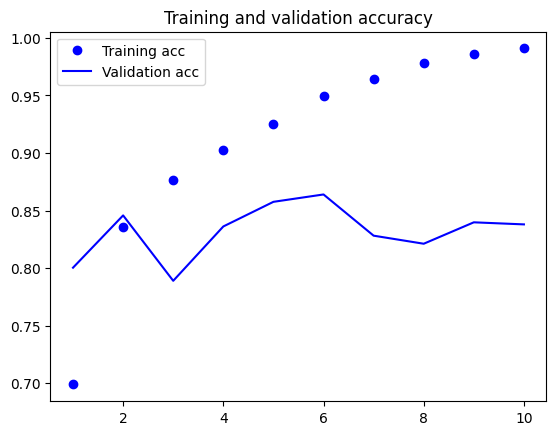

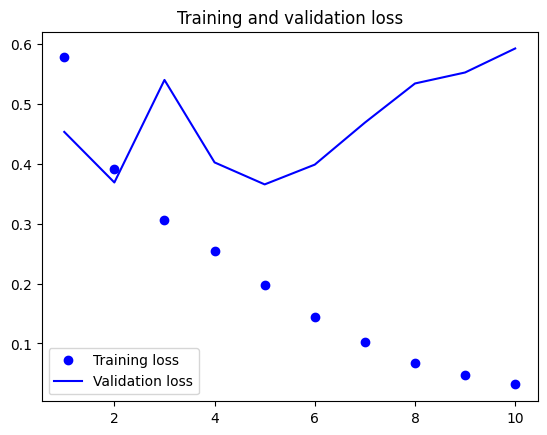

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Note that we have only considered the first 500 words, rather than full sequences and we obtain already an accuracy of $86.3\%$. Now let's implement a more advanced RNN, say LSTM.


### Step 5. Loading and testing saved model

In [ ]:
from tensorflow.keras.models import model_from_json

# Model reconstruction from JSON file
with open(MODEL_DIR + "simpleRNN_500.json", "r") as f:
    model = model_from_json(f.read())

In [ ]:
from tensorflow.keras.models import load_model

model.load_weights(MODEL_DIR +"simpleRNN_500.h5")

In [ ]:
import keras

INDEX_FROM=3   # word index offset
word_to_id = keras.datasets.imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

#id_to_word = {value:key for key,value in word_to_id.items()}
#print("Negative review \n")
#print(' '.join(id_to_word[id] for id in input_train[2] ))
#print("\n Positive review \n")
#print(' '.join(id_to_word[id] for id in input_train[10] ))

1641221/1641221 [==============================] - 0s 0us/step


In [ ]:
import numpy as np

#predict sentiment from reviews
max_review_length=500
bad = "this movie was bad and terrible i almost die"
good = "not bad"
neutral = "it was good"
vague = "it was great"

for review in [bad,good,neutral,vague]:
    tmp = []
    for word in review.split(" "):
        tmp.append(word_to_id[word])
    tmp_padded = sequence.pad_sequences([tmp], maxlen=max_review_length)
    print("%s. Sentiment: %s" % (review,model.predict(np.array([tmp_padded][0]))[0][0]))

1/1 [==============================] - 0s 206ms/step
this movie was bad and terrible i almost die. Sentiment: 0.003674247
1/1 [==============================] - 0s 45ms/step
not bad. Sentiment: 0.9933981
1/1 [==============================] - 0s 51ms/step
it was good. Sentiment: 0.99974877
1/1 [==============================] - 0s 57ms/step
it was great. Sentiment: 0.99990416


# 3. Long short-term memory (LSTM)
---
LSTMs were first introduced to overcome the vanishing gradient problem (Long Short-Term Memory, S. Hochreiter and J. Schmidhuber, Neural Computation, 9(8): 1735-1780, 1997). The building block of an LSTM is a memory cell, which
essentially represents the hidden layer.

First recall that the simple RNN is given by the schematics below:

<img width="673" alt="RNN_simple" src="https://user-images.githubusercontent.com/25600601/142830937-1f49a738-ba3b-4938-9d11-24638f7448c7.png">

In each memory cell, there is a recurrent edge that has the desirable weight w =1, as we discussed previously, to overcome the vanishing and exploding gradient problems. The values associated with this recurrent edge is called cell state. The unfolded structure of a modern LSTM cell is shown in the following figure:

<img width="1021" alt="RNN_LSTM" src="https://user-images.githubusercontent.com/25600601/142831002-2544020d-36e3-4976-b0d1-7fc8fc4f0cdb.png">

Notice that the cell state from the previous time step, $\mathbf{C}^{(t−1)}$, is modified to get the cell
state at the current time step,  $\mathbf{C}^{(t)}$ , without being multiplied directly with any weight
factor. For comparison, here is how the simple RNN is changed by LSTM:

<img width="701" alt="RNN_LSTM2" src="https://user-images.githubusercontent.com/25600601/142831098-289119a4-8331-4cde-a823-5493354ccd1d.png">

The flow of information in this memory cell is controlled by some units of computation that we'll describe here. In the previous figure, $\odot$ refers to the element-wise product (element-wise multiplication) and means $\oplus$ element-wise summation (element-wise addition). Furthermore, $\mathbf{x}^{(t)}$ refers to the input data at time t, and $\mathbf{h}^{(t−1)}$ indicates the hidden units at time t −1.

Four boxes are indicated with an activation function, either the sigmoid function ($\sigma$) or hyperbolic tangent ($\tanh$), and a set of weights; these boxes apply linear combination by performing matrix-vector multiplications on their input. These units of computation with sigmoid activation functions, whose output units are passed through $\odot$, are called **gates**.

In an LSTM cell, there are three different types of gates, known as the forget gate, the
input gate, and the output gate:

• The **forget gate** ($\mathbf{f}_t$) allows the memory cell to reset the cell state without growing indefinitely. In fact, the forget gate decides which information is allowed to go through and which information to suppress. Now, $\mathbf{f}_t$ is computed as follows:

\begin{equation}
\mathbf{f}_{t}= \sigma(\mathbf{W}_{xf}\mathbf{x}^{(t)} + \mathbf{W}_{hf}\mathbf{h}^{(t-1)} + \mathbf{b}_{f})
\end{equation}

Note that the forget gate was not part of the original LSTM cell; it was added a few years later to improve the original model (*Learning to Forget: Continual Prediction with LSTM, F. Gers, J. Schmidhuber, and F. Cummins, Neural Computation 12, 2451-2471, 2000*).

• The **input gate** ($\mathbf{i}_t$) and **input node** ( $\mathbf{g}_t$ ) are responsible for updating the cell
state. They are computed as follows:

\begin{equation}
\mathbf{i}_{t}= \sigma(\mathbf{W}_{xi}\mathbf{x}^{(t)} + \mathbf{W}_{hi}\mathbf{h}^{(t-1)} + \mathbf{b}_{i})
\end{equation}

\begin{equation}
\mathbf{g}_{t}= \tanh(\mathbf{W}_{xg}\mathbf{x}^{(t)} + \mathbf{W}_{hg}\mathbf{h}^{(t-1)} + \mathbf{b}_{g})
\end{equation}

The cell state at time t is computed as follows:

\begin{equation}
\mathbf{C}^{t}= (\mathbf{C}^{t-1} \odot \mathbf{f}_{t}) \oplus (\mathbf{i}_{t} \odot \mathbf{g}_{t})
\end{equation}

The output gate ($\mathbf{o}_t$ ) decides how to update the values of hidden units:

\begin{equation}
\mathbf{o}_{t}= \sigma(\mathbf{W}_{xo}\mathbf{x}^{(t)} + \mathbf{W}_{ho}\mathbf{h}^{(t-1)} \mathbf{b}_{o})
\end{equation}


Given this, the hidden units at the current time step are computed as follows:

\begin{equation}
\mathbf{h}_{t}= \mathbf{o}_{t} \odot \tanh(\mathbf{C}^{t})
\end{equation}

The structure of an LSTM cell and its underlying computations might seem too complex. However, the good news is that TensorFlow has already implemented everything in wrapper functions that allows us to define our LSTM cells easily.

NOTE: The LSTM introduced here provides a basic approach for modeling long-range dependencies in sequences.
Yet, it is important to note that there are many variations of LSTMs described in literature (An Empirical Exploration of Recurrent Network Architectures, Rafal Jozefowicz, Wojciech Zaremba, and Ilya Sutskever,
Proceedings of ICML, 2342-2350, 2015). Also, worth noting is a more recent approach, called Gated Recurrent Unit (GRU), which was proposed in 2014. GRUs have a simpler architecture than LSTMs; therefore, they are computationally more efficient while their performance in some tasks, such as polyphonic music modeling, is comparable to LSTMs. If you are interested in learning more about these modern RNN architectures, refer to the paper, Empirical Evaluation of Gated Recurrent Neural Networks on Sequence Modeling by Junyoung Chung
and others 2014 (https://arxiv.org/pdf/1412.3555v1.pdf). Implementation of such can be an individual project.

*Intuitive idea from Chollet:  The Carry layer $C$ intends to add a way to carry information across many timesteps. Imagine a conveyor belt running parallel to the sequence you’re processing. Information from the sequence can jump onto the conveyor belt at any point, be transported to a later timestep, and jump off, intact, when you need it. This is essentially what LSTM does: it saves information for later, thus preventing older signals from gradually vanishing during processing.*

If you want to get philosophical, you can interpret what each of these operations is meant to do. For instance, you can say that multiplying $\mathbf{C}^{(t)}$ and $\mathbf{f}_{(t)}$ is a way to deliberately forget irrelevant information in the carry dataflow. Meanwhile, $\mathbf{i}_{(t)}$ and $\mathbf{g}_{(t)}$ provide information about the present, updating the carry track with new information.

But at the end of the day, these interpretations don’t mean much, because what these operations actually do is determined by the contents of the weights parameterizing them; and the weights are learned in an end-to-end fashion, starting over with each training round, making it impossible to credit this or that operation with a specific purpose. The specification of an RNN cell (as just described) determines your hypothesis
space—the space in which you’ll search for a good model configuration during training—but it doesn’t determine what the cell does; that is up to the cell weights.

The same cell with different weights can be doing very different things. So the combination of operations making up an RNN cell is better interpreted as a set of constraints on your search, not as a design in an engineering sense.

To a researcher, it seems that the choice of such constraints—the question of how to implement RNN cells—is better left to optimization algorithms (like genetic algorithms or reinforcement learning processes) than to human engineers. And in the future, that’s how we’ll build networks.

<div class="alert alert-block alert-success">
Keep in mind what the LSTM cell is meant to do: allow past information to be reinjected at a later time, thus fighting the vanishing-gradient problem.
</div>

# Example 1B. Sentiment analysis of IMDb movie reviews using a simple LSTM

We will implement a multilayer RNN for sentiment analysis using a many-to-one architecture.

### Step 1. Data Preparation
Already done above.

### Step 2. Using LSTM

In [ ]:
from keras.layers import LSTM
from keras import Sequential

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 328353 (1.25 MB)
Trainable params: 328353 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])

history = model.fit(input_train, y_train,
epochs=10,
batch_size=128,
validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 16s 87ms/step - loss: 0.6042 - acc: 0.6622 - val_loss: 0.4245 - val_acc: 0.8270
Epoch 2/10
157/157 [==============================] - 10s 63ms/step - loss: 0.3572 - acc: 0.8504 - val_loss: 0.4183 - val_acc: 0.8110
Epoch 3/10
157/157 [==============================] - 9s 56ms/step - loss: 0.2697 - acc: 0.8950 - val_loss: 0.2881 - val_acc: 0.8838
Epoch 4/10
157/157 [==============================] - 7s 44ms/step - loss: 0.2313 - acc: 0.9118 - val_loss: 0.4483 - val_acc: 0.8440
Epoch 5/10
157/157 [==============================] - 5s 34ms/step - loss: 0.2035 - acc: 0.9238 - val_loss: 0.3344 - val_acc: 0.8850
Epoch 6/10
157/157 [==============================] - 5s 34ms/step - loss: 0.1804 - acc: 0.9338 - val_loss: 0.3470 - val_acc: 0.8576
Epoch 7/10
157/157 [==============================] - 5s 30ms/step - loss: 0.1638 - acc: 0.9424 - val_loss: 0.3294 - val_acc: 0.8762
Epoch 8/10
157/157 [==============================] - 4s 28ms/step 

### Step 3. Save the Model

In [ ]:
# serialize/save model architecture to JSON
model_json = model.to_json()
with open(MODEL_DIR + "LSTM_500.json", "w") as json_file:
    json_file.write(model_json)

# serialize/save weights to HDF5
model.save_weights(MODEL_DIR + "LSTM_500.h5")
print("Saved model to disk")

Saved model to disk


### Step 4. Plot the result accuracy for visual appreciation.

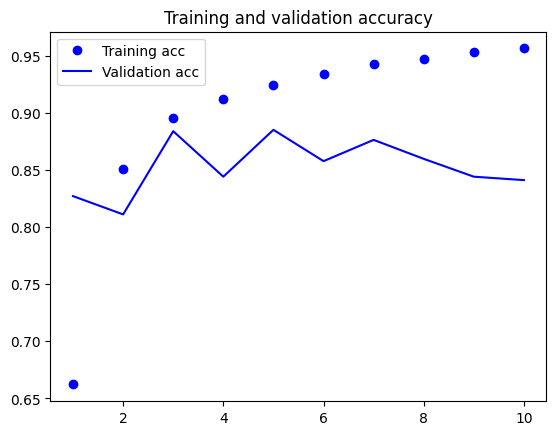

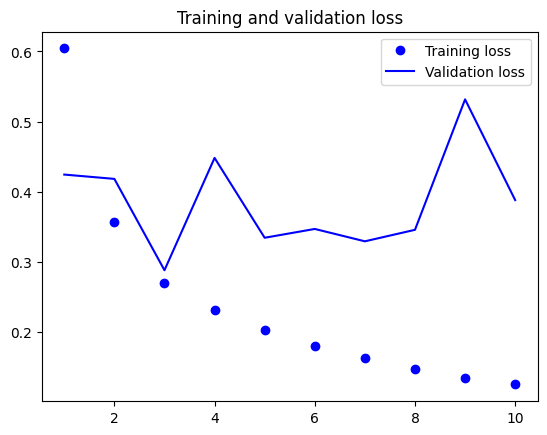

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

This time, you achieve up to 88.3% validation accuracy. That's not bad; better than the SimpleRNN network. That’s largely because LSTM suffers much less from the vanishing-gradient problem.

But this result isn’t groundbreaking for such a computationally intensive approach. Why isn’t LSTM performing better? One reason is that you made no effort to tune hyperparameters such as the embeddings dimensionality or the LSTM output dimensionality. Another may be lack of regularization. But honestly, the primary reasons that analyzing the global, long-term structure of the reviews (what LSTM is good at) isn’t helpful for a sentiment-analysis problem. Such a basic problem is well solved by looking at what words occur in each review, and at what frequency. That’s what the first fully connected approach looked at. But there are far more difficult natural language- processing problems out there, where the strength of LSTM will become apparent: in particular, **question-answering** and **machine translation.**

### Step 5. Loading and testing saved model

In [ ]:
from tensorflow.keras.models import model_from_json

# Model reconstruction from JSON file
with open(MODEL_DIR + "LSTM_500.json", "r") as f:
    model = model_from_json(f.read())

In [ ]:
from tensorflow.keras.models import load_model

model.load_weights(MODEL_DIR +"LSTM_500.h5")

In [ ]:

import numpy as np

#predict sentiment from reviews
max_review_length=1000
bad = "this movie was bad and terrible i almost die not brilliant it is really terrible and brilliant"
good = "not brilliant"
neutral = "it is really terrible and brilliant"
vague = "somewhere somehow"


for review in [bad,good,neutral,vague]:
    tmp = []
    for word in review.split(" "):
        tmp.append(word_to_id[word])
    tmp_padded = sequence.pad_sequences([tmp], maxlen=max_review_length)
    print("%s. Sentiment: %s" % (review,model.predict(np.array([tmp_padded][0]))[0][0]))

1/1 [==============================] - 0s 365ms/step
this movie was bad and terrible i almost die not brilliant it is really terrible and brilliant. Sentiment: 0.1943111
1/1 [==============================] - 0s 25ms/step
not brilliant. Sentiment: 0.66626
1/1 [==============================] - 0s 25ms/step
it is really terrible and brilliant. Sentiment: 0.532872
1/1 [==============================] - 0s 24ms/step
somewhere somehow. Sentiment: 0.29331592


# Example 1C. Increasing nodes
What if we increase the number of nodes of the embedding layer? Can this immediately increase the accuracy?

### Step 1. Data Preparation

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence
max_features = 10000 #Number of words to consider as features
maxlen = 500 # Cuts off texts after this many words (among the max_features most common words)
#batch_size = 32
print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(
num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')
print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


### Step 2. Instantiate the model and Run. Let's just increase the embedding nodes from 32 to 64.

In [ ]:
from keras import Sequential
from keras.layers import Embedding, SimpleRNN
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 64))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          640000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 643137 (2.45 MB)
Trainable params: 643137 (2.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
epochs=10,
batch_size=128,
validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 86s 537ms/step - loss: 0.5977 - acc: 0.6736 - val_loss: 0.4545 - val_acc: 0.8174
Epoch 2/10
157/157 [==============================] - 81s 516ms/step - loss: 0.3713 - acc: 0.8488 - val_loss: 0.3541 - val_acc: 0.8554
Epoch 3/10
157/157 [==============================] - 76s 486ms/step - loss: 0.2872 - acc: 0.8877 - val_loss: 0.3547 - val_acc: 0.8520
Epoch 4/10
157/157 [==============================] - 76s 488ms/step - loss: 0.2647 - acc: 0.9010 - val_loss: 0.4542 - val_acc: 0.7846
Epoch 5/10
157/157 [==============================] - 72s 460ms/step - loss: 0.1869 - acc: 0.9317 - val_loss: 0.3637 - val_acc: 0.8670
Epoch 6/10
157/157 [==============================] - 72s 457ms/step - loss: 0.1481 - acc: 0.9503 - val_loss: 0.4037 - val_acc: 0.8586
Epoch 7/10
157/157 [==============================] - 71s 453ms/step - loss: 0.1243 - acc: 0.9620 - val_loss: 0.4465 - val_acc: 0.8598
Epoch 8/10
157/157 [==============================] - 7

### Step 3. Again, let's save the model.

In [ ]:
# serialize/save model architecture to JSON
model_json = model.to_json()
with open(MODEL_DIR + "simpleRNN_64_500.json", "w") as json_file:
    json_file.write(model_json)

# serialize/save weights to HDF5
model.save_weights(MODEL_DIR + "simpleRNN_64_500.h5")
print("Saved model to disk")

Saved model to disk


### Step 4. Visualization of Learning generalization.

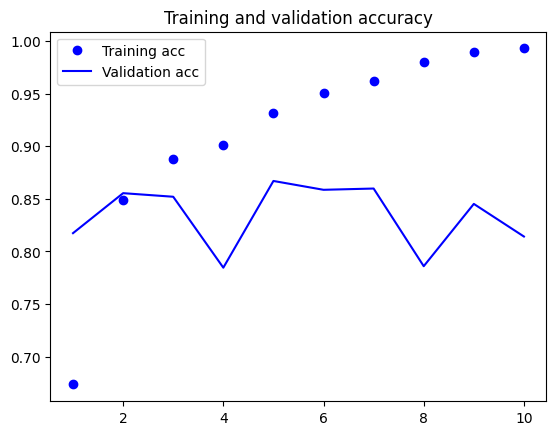

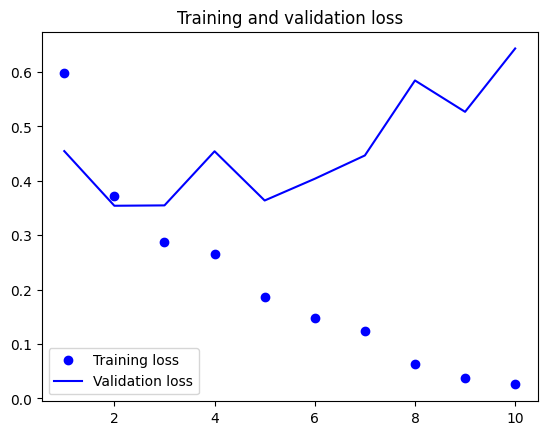

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

The result gives almost the same accuracy as embedding nodes of 32. The result will also not significantly increase as a result of the addition of more features (verify). The primary reason is that analyzing the global, long-term structure of the reviews isn’t helpful for a sentiment-analysis problem. Such a basic problem is well solved by looking at what words occur in each review, and at what frequency.

### Step 5. Loading and testing saved model

In [ ]:
from tensorflow.keras.models import model_from_json

# Model reconstruction from JSON file
with open(MODEL_DIR + "simpleRNN_64_500.json", "r") as f:
    model = model_from_json(f.read())

In [ ]:
from tensorflow.keras.models import load_model
model.load_weights(MODEL_DIR + "simpleRNN_64_500.h5")

In [ ]:
import keras

INDEX_FROM=3   # word index offset
word_to_id = keras.datasets.imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2
id_to_word = {value:key for key,value in word_to_id.items()}
print("Negative review \n")
print(' '.join(id_to_word[id] for id in input_train[10] ))
print("\n Positive review \n")
print(' '.join(id_to_word[id] for id in input_train[42] ))

Negative review 

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> french horror cinema has seen something of a revival over the last couple of years with great films such as inside and <UNK> romance <UNK> on to the scene <UNK> <UNK> the revival just slightly but stands head and shoulders over most modern horror titles and is surely one of the best french horror films ever made <UNK> was obviously shot on a low budget but this is made up for in far more ways than one by the originality of the film and this in turn is <UNK> by the excellent writing and acting that ensure the film is a winner the plot focuses on two main ideas prison and black magic the central character is a man named <UNK> sent to prison for fraud he is put in a ce

In [ ]:
import numpy as np

#predict sentiment from reviews
max_review_length=500
bad = "this movie was bad and terrible i almost die"
good = "brilliant movie a masterpiece"
neutral = "it is really terrible and brilliant"
vague = "somewhere somehow"

for review in [bad,good,neutral,vague]:
    tmp = []
    for word in review.split(" "):
        tmp.append(word_to_id[word])
    tmp_padded = sequence.pad_sequences([tmp], maxlen=max_review_length)
    print("%s. Sentiment: %s" % (review,model.predict(np.array([tmp_padded][0]))[0][0]))

1/1 [==============================] - 0s 186ms/step
this movie was bad and terrible i almost die. Sentiment: 0.0004628647
1/1 [==============================] - 0s 45ms/step
brilliant movie a masterpiece. Sentiment: 0.8679258
1/1 [==============================] - 0s 44ms/step
it is really terrible and brilliant. Sentiment: 0.560862
1/1 [==============================] - 0s 45ms/step
somewhere somehow. Sentiment: 0.080837466


<div class="alert alert-block alert-info">

# ⚠️ Checkpoint ⚠️

In the next 5-10 minutes, review the 3 main RNNs that we've gone over and compare them with each other. What are the similarities and differences with them? Make sure your LT understands.
</div>

# Appendix A. Link for step by step understanding of the process

https://www.liip.ch/en/blog/sentiment-detection-with-keras-word-embeddings-and-lstm-deep-learning-networks

### Step 1. Get the data

In [ ]:
#download the data
from keras.datasets import imdb
top_words = 500
(input_train, output_train), (input_test, output_test) = imdb.load_data(num_words=top_words)

The code above does a couple of things at once:
1. It downloads the data   
2. It downloads the first 5000 top words for each review   
3. It splits the data into a test and a training set.  

In [ ]:
input_train

array([list([1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]),
       list([1, 194, 2, 194, 2, 78, 228, 5, 6, 2, 2, 2, 134, 26, 4, 2, 8, 118, 2, 14, 394, 20, 13, 119, 2, 189, 102, 5, 207, 110, 2, 21, 

If you look at the data you will realize it has been already pre-processed. All words have been mapped to integers and the integers represent the words sorted by their frequency. This is very common in text analysis to represent a dataset like this. So 4 represents the 4th most used word, 5 the 5th most used word and so on... The integer 1 is reserved reserved for the start marker, the integer 2 for an unknown word and 0 for padding.

If you want to peek at the reviews yourself and see what people have actually written, you can reverse the process too:

In [ ]:
#reverse lookup
word_to_id = keras.datasets.imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2
id_to_word = {value:key for key,value in word_to_id.items()}
print(' '.join(id_to_word[id] for id in input_train[1] ))

<START> big <UNK> big <UNK> bad music and a <UNK> <UNK> <UNK> these are the <UNK> to best <UNK> this terrible movie i love <UNK> horror movies and i've seen <UNK> but this had got to be on of the worst ever made the plot is <UNK> <UNK> and <UNK> the acting is an <UNK> the script is completely <UNK> the best is the end <UNK> with the <UNK> and how he <UNK> out who the killer is it's just so <UNK> <UNK> written the <UNK> are <UNK> and funny in <UNK> <UNK> the <UNK> is big <UNK> of <UNK> <UNK> men <UNK> those <UNK> <UNK> <UNK> that show off their <UNK> <UNK> that men actually <UNK> them and the music is just <UNK> <UNK> that plays over and over again in almost every scene there is <UNK> music <UNK> and <UNK> <UNK> away <UNK> and the <UNK> still doesn't close for <UNK> all <UNK> <UNK> this is a truly bad film <UNK> only <UNK> is to look back on the <UNK> that was the <UNK> and have a good old laugh at how bad everything was back then


### Step 2. Preprocess the data

Since the reviews differ heavily in terms of lengths we want to trim each review to its first 500 words. We need to have text samples of the same length in order to feed them into our neural network. If reviews are shorter than 500 words we will pad them with zeros. Keras being super nice, offers a set of preprocessing routines that can do this for us easily.

In [ ]:
# Truncate and pad the review sequences
from keras.preprocessing import sequence
max_review_length = 500
input_train = sequence.pad_sequences(input_train, maxlen=max_review_length)
input_test = sequence.pad_sequences(input_test, maxlen=max_review_length)

### Step 3. Build the model

Surprisingly we are already done with the data preparation and can already start to build our model.

In [ ]:
# Build the model
from keras.layers import LSTM

embedding_vector_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 500, 32)           16000     
                                                                 
 lstm_1 (LSTM)               (None, 100)               53200     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 69301 (270.71 KB)
Trainable params: 69301 (270.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


The two most important things in our code are the following:

The Embedding layer and
The LSTM Layer.

### Word embeddings

The embedding layer will learn a word embedding for all the words in the dataset. It has three arguments the input_dimension in our case the 500 words. The output dimension aka the vector space in which words will be embedded. In our case we have chosen 32 dimensions so a vector of the length of 32 to hold our word coordinates.

There are already pre-trained word embeddings (e.g. GloVE or Word2Vec) that you can download so that you don't have to train your embeddings all by yourself. Generally, these word embeddings are also based on specialized algorithms that do the embedding always a bit different, but we won't cover it here.

How can you imagine what an embedding actually is? Well generally words that have a similar meaning in the context should be embedded next to each other. Below is an example of word embeddings in a two-dimensional space:

<img width="712" alt="RNN_embeddings" src="https://user-images.githubusercontent.com/25600601/142831953-676b94a7-699f-490a-a04f-bade320b2dcc.png">


Why should we even care about word embeddings? Because it is a really useful trick. If we were to feed our reviews into a neural network and just one-hot encode them we would have very sparse representations of our texts. Why? Let us have a look at the sentence "I do my job" in "bag of words" representation with a vocabulary of 1000: So a matrix that holds 1000 words (each column is one word), has four ones in it (one for I, one for do one for my and one for job) and 996 zeros. So it would be very sparse. This means that learning from it would be difficult, because we would need 1000 input neurons each representing the occurrence of a word in our sentence.

In contrast if we do a word embedding we can fold these 1000 words in just as many dimensions as we want, in our case 32. This means that we just have an input vector of 32 values instead of 1000. So the word "I" would be some vector with values (0.4,0.5,0.2,...) and the same would happen with the other words. With word embedding like this, we just need 32 input neurons.

Note that Keras utilizes Glove or Global Vectors developed by Pennington et al 2015. Here is a good blog on word embeddings, that among others, discusses how Glove is different from word2vec created by Mikalov et al in 2014: https://medium.com/@ppasumarthi_69210/word-embeddings-in-keras-be6bb3092831

### LSTMs

Recurrent neural networks are networks that are used for "things" that happen recurrently so one thing after the other (e.g. time series, but also words). Long Short-Term Memory networks (LSTM) are a specific type of Recurrent Neural Network (RNN) that are capable of learning the relationships between elements in an input sequence. In our case the elements are words. So our next layer is an LSTM layer with 100 memory units.

LSTM networks maintain a state, and so overcome the problem of a vanishing gradient problem in recurrent neural networks (basically the problem that when you make a network deep enough the information for learning will "vanish" at some point). I do not want to go into detail how they actually work, but here delivers a great visual explanation. Below is a schematic overview over the building blocks of LSTMs.

So our output of the embedding layer is a 500 times 32 matrix. Each word is represented through its position in those 32 dimensions. And the sequence is the 500 words that we feed into the LSTM network.

Finally at the end we have a dense layer with one node with a sigmoid activation as the output.

Since we are going to have only the decision when the review is positive or negative we will use binary_crossentropy for the loss function. The optimizer is the standard one (adam) and the metrics are also the standard accuracy metric.



In [ ]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 32)          320000    
                                                                 
 lstm_2 (LSTM)               (None, 100)               53200     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 373301 (1.42 MB)
Trainable params: 373301 (1.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(input_train, output_train,
epochs=10,
batch_size=128,
validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 8s 35ms/step - loss: 0.6611 - acc: 0.5932 - val_loss: 0.4971 - val_acc: 0.7612
Epoch 2/10
157/157 [==============================] - 5s 30ms/step - loss: 0.4999 - acc: 0.7628 - val_loss: 0.4416 - val_acc: 0.7996
Epoch 3/10
157/157 [==============================] - 5s 29ms/step - loss: 0.4592 - acc: 0.7925 - val_loss: 0.4229 - val_acc: 0.8098
Epoch 4/10
157/157 [==============================] - 5s 29ms/step - loss: 0.4340 - acc: 0.8049 - val_loss: 0.5286 - val_acc: 0.7720
Epoch 5/10
157/157 [==============================] - 5s 31ms/step - loss: 0.4270 - acc: 0.8112 - val_loss: 0.5602 - val_acc: 0.7894
Epoch 6/10
157/157 [==============================] - 5s 30ms/step - loss: 0.4116 - acc: 0.8234 - val_loss: 0.4563 - val_acc: 0.8070
Epoch 7/10
157/157 [==============================] - 5s 29ms/step - loss: 0.4056 - acc: 0.8251 - val_loss: 0.4118 - val_acc: 0.8116
Epoch 8/10
157/157 [==============================] - 5s 30ms/step - 

### LSTM Number of Parameters

The LSTM has a set of 2 matrices: U and W for each of the (3) gates. The $\odot$ in the diagram indicates multiplication of these matrices with the input and output.

U has dimensions n×mn×m  
W has dimensions n×nn×n  

there is a different set of these matrices for each of the three gates(like UforgetUforget for the forget gate etc.)
there is another set of these matrices for updating the cell state S
on top of the mentioned matrices, you need to count the biases (not in the picture)
Hence total # parameters = 4(nm+$n^2$+n)

# Appendix B. Checkpoint for validation

https://machinelearningmastery.com/check-point-deep-learning-models-keras/

A good use of checkpointing is to output the model weights each time an improvement is observed during training.

The example below creates a small neural network for the Pima Indians onset of diabetes binary classification problem. The example assume that the pima-indians-diabetes.csv file is in your working directory. You can download this dataset from the UCI machine learning repository (update: download from here). The example uses 33% of the data for validation.

Checkpointing is setup to save the network weights only when there is an improvement in classification accuracy on the validation dataset (monitor=’val_acc’ and mode=’max’).

**The weights are stored in a file that includes the score in the filename (weights-improvement-{val_acc=.2f}.hdf5).**

In [ ]:
# Checkpoint the weights when validation accuracy improves
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# load pima indians dataset
dataset = numpy.loadtxt(DATA_DIR + "/pima-indians-diabetes.data.csv", delimiter=",")

# split into input (X) and output (Y) variables
X = dataset[:,0:8]
Y = dataset[:,8]

# create model
model = Sequential()
model.add(Dense(12, input_dim=8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# checkpoint

filepath=MODEL_DIR + "weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5" #Save the Improve model here
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Fit the model
model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, callbacks=callbacks_list, verbose=0)


Epoch 1: val_accuracy improved from -inf to 0.67323, saving model to /content/drive/MyDrive/COSCI224 Machine Learning 3 Notebooks/models/weights-improvement-01-0.67.hdf5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy did not improve from 0.67323

Epoch 3: val_accuracy did not improve from 0.67323

Epoch 4: val_accuracy did not improve from 0.67323

Epoch 5: val_accuracy did not improve from 0.67323

Epoch 6: val_accuracy did not improve from 0.67323

Epoch 7: val_accuracy improved from 0.67323 to 0.68504, saving model to /content/drive/MyDrive/COSCI224 Machine Learning 3 Notebooks/models/weights-improvement-07-0.69.hdf5

Epoch 8: val_accuracy did not improve from 0.68504

Epoch 9: val_accuracy improved from 0.68504 to 0.68898, saving model to /content/drive/MyDrive/COSCI224 Machine Learning 3 Notebooks/models/weights-improvement-09-0.69.hdf5

Epoch 10: val_accuracy did not improve from 0.68898

Epoch 11: val_accuracy did not improve from 0.68898

Epoch 12: val_accuracy did not improve from 0.68898

Epoch 13: val_accuracy did not improve from 0.68898

Epoch 14: val_accuracy did not improve from 0.68898

Epoch 15: val_accuracy did not improve from 0.68898

Epoch 16: val_accurac

### Checkpoint Best Neural Network Model Only

A simpler check-point strategy is to save the model weights to the same file, if and only if the validation accuracy improves. This can be done easily using the same code from above and changing the output filename to be fixed (not include score or epoch information).

In this case, model weights are written to the file “weights.best.hdf5” only if the classification accuracy of the model on the validation dataset improves over the best seen so far.

You should see the weight file in your local directory: "weights.best.hdf5"

In [ ]:
# Checkpoint the weights for best model on validation accuracy
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# load pima indians dataset
dataset = numpy.loadtxt(DATA_DIR + "/pima-indians-diabetes.data.csv", delimiter=",")
# split into input (X) and output (Y) variables
X = dataset[:,0:8]
Y = dataset[:,8]

# create model
model = Sequential()
model.add(Dense(12, input_dim=8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# checkpoint
filepath=MODEL_DIR+"weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
# Fit the model
model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, callbacks=callbacks_list, verbose=0)


Epoch 1: val_accuracy improved from -inf to 0.67323, saving model to /content/drive/MyDrive/COSCI224 Machine Learning 3 Notebooks/models/weights.best.hdf5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy did not improve from 0.67323

Epoch 3: val_accuracy did not improve from 0.67323

Epoch 4: val_accuracy improved from 0.67323 to 0.68110, saving model to /content/drive/MyDrive/COSCI224 Machine Learning 3 Notebooks/models/weights.best.hdf5

Epoch 5: val_accuracy did not improve from 0.68110

Epoch 6: val_accuracy did not improve from 0.68110

Epoch 7: val_accuracy did not improve from 0.68110

Epoch 8: val_accuracy improved from 0.68110 to 0.68504, saving model to /content/drive/MyDrive/COSCI224 Machine Learning 3 Notebooks/models/weights.best.hdf5

Epoch 9: val_accuracy did not improve from 0.68504

Epoch 10: val_accuracy did not improve from 0.68504

Epoch 11: val_accuracy improved from 0.68504 to 0.70866, saving model to /content/drive/MyDrive/COSCI224 Machine Learning 3 Notebooks/models/weights.best.hdf5

Epoch 12: val_accuracy did not improve from 0.70866

Epoch 13: val_accuracy did not improve from 0.70866

Epoch 14: val_accuracy did not improve from 0.7086

### Loading a Neural Network Model Checkpoint

Now that you have seen how to checkpoint your deep learning models during training, you need to review how to load and use a checkpointed model.The checkpoint only includes the model weights. It assumes you know the network structure.

In the example below, the model structure is known and the best weights are loaded from the previous experiment, stored in the working directory in the weights.best.hdf5 file.

The model is then used to make predictions on the entire dataset.

In [ ]:
# How to load and use weights from a checkpoint

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# create model
model = Sequential()
model.add(Dense(12, input_dim=8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

# load weights
model.load_weights(MODEL_DIR + "weights.best.hdf5")
# Compile model (required to make predictions)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Created model and loaded weights from file")

# load pima indians dataset
dataset = numpy.loadtxt(DATA_DIR + "/pima-indians-diabetes.data.csv", delimiter=",")

# split into input (X) and output (Y) variables
X = dataset[:,0:8]
Y = dataset[:,8]

# estimate accuracy on whole dataset using loaded weights
scores = model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Created model and loaded weights from file
accuracy: 77.73%


### Let's use the IMdB data set

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence
max_features = 10000 #Number of words to consider as features
maxlen = 500 # Cuts off texts after this many words (among the max_features most common words)
#batch_size = 32
print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(
num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')
print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


In [ ]:
from keras import Sequential
from keras.layers import Embedding, SimpleRNN
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# checkpoint
filepath=MODEL_DIR+ "weights_best_IMDB2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=callbacks_list, verbose=0)



Epoch 1: val_acc improved from -inf to 0.70700, saving model to /content/drive/MyDrive/COSCI224 Machine Learning 3 Notebooks/models/weights_best_IMDB2.hdf5

Epoch 2: val_acc improved from 0.70700 to 0.82200, saving model to /content/drive/MyDrive/COSCI224 Machine Learning 3 Notebooks/models/weights_best_IMDB2.hdf5

Epoch 3: val_acc improved from 0.82200 to 0.85520, saving model to /content/drive/MyDrive/COSCI224 Machine Learning 3 Notebooks/models/weights_best_IMDB2.hdf5

Epoch 4: val_acc improved from 0.85520 to 0.87180, saving model to /content/drive/MyDrive/COSCI224 Machine Learning 3 Notebooks/models/weights_best_IMDB2.hdf5

Epoch 5: val_acc did not improve from 0.87180

Epoch 6: val_acc did not improve from 0.87180

Epoch 7: val_acc did not improve from 0.87180

Epoch 8: val_acc did not improve from 0.87180

Epoch 9: val_acc did not improve from 0.87180

Epoch 10: val_acc did not improve from 0.87180


# Appendix C. Multilayer RNN with Dropout Regularization

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence
max_features = 10000 #Number of words to consider as features
maxlen = 500 # Cuts off texts after this many words (among the max_features most common words)
#batch_size = 32
print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(
num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')
print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


In [ ]:
from keras.layers import LSTM
from keras import Sequential
from keras.layers import Dropout
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(16, return_sequences=True,
              input_shape=(None,None, 16)))
model.add(LSTM(16, return_sequences=True,
              input_shape=(None,None, 16)))
model.add(LSTM(16))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 32)          320000    
                                                                 
 lstm_6 (LSTM)               (None, None, 16)          3136      
                                                                 
 lstm_7 (LSTM)               (None, None, 16)          2112      
                                                                 
 lstm_8 (LSTM)               (None, 16)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_20 (Dense)            (None, 1)                 17        
                                                                 
Total params: 327377 (1.25 MB)
Trainable params: 3273

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# checkpoint
filepath=MODEL_DIR+ "weights_best_IMDB2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=callbacks_list, verbose=0)


Epoch 1: val_acc improved from -inf to 0.80760, saving model to /content/drive/MyDrive/COSCI224 Machine Learning 3 Notebooks/models/weights_best_IMDB2.hdf5

Epoch 2: val_acc improved from 0.80760 to 0.85860, saving model to /content/drive/MyDrive/COSCI224 Machine Learning 3 Notebooks/models/weights_best_IMDB2.hdf5

Epoch 3: val_acc did not improve from 0.85860

Epoch 4: val_acc improved from 0.85860 to 0.88420, saving model to /content/drive/MyDrive/COSCI224 Machine Learning 3 Notebooks/models/weights_best_IMDB2.hdf5

Epoch 5: val_acc did not improve from 0.88420

Epoch 6: val_acc did not improve from 0.88420

Epoch 7: val_acc did not improve from 0.88420

Epoch 8: val_acc did not improve from 0.88420

Epoch 9: val_acc did not improve from 0.88420

Epoch 10: val_acc did not improve from 0.88420


In [ ]:
model_json = model.to_json()
with open(MODEL_DIR + "model_multiLSTM.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
from tensorflow.keras.models import model_from_json

# Model reconstruction from JSON file
with open(MODEL_DIR + "model_multiLSTM.json", "r") as f:
    model = model_from_json(f.read())

from tensorflow.keras.models import load_model

model.load_weights(MODEL_DIR +"weights_best_IMDB2.hdf5")

In [ ]:
import numpy as np

#predict sentiment from reviews
max_review_length=500
bad = "this movie was bad and terrible i almost die"
good = "not good"
neutral = "it is really terrible and brilliant"
vague = "somewhere somehow"

for review in [bad,good,neutral,vague]:
    tmp = []
    for word in review.split(" "):
        tmp.append(word_to_id[word])
    tmp_padded = sequence.pad_sequences([tmp], maxlen=max_review_length)
    print("%s. Sentiment: %s" % (review,model.predict(np.array([tmp_padded][0]))[0][0]))

1/1 [==============================] - 1s 1s/step
this movie was bad and terrible i almost die. Sentiment: 0.074548006
1/1 [==============================] - 0s 39ms/step
not good. Sentiment: 0.14470227
1/1 [==============================] - 0s 37ms/step
it is really terrible and brilliant. Sentiment: 0.19832663
1/1 [==============================] - 0s 32ms/step
somewhere somehow. Sentiment: 0.13511896
